# Train a Production Model

This tutorial will use AMPL to take the best performing model with the highest validation score from the previous Tutorial 7 and train a production model using all available data. The production model is used for model deployment. The production model could be shared with other researchers to predict on new data. When there is an updated version of the model input datasets or an updated major AMPL version, a new version of the production model should be created. Production model versions could be used to assess prediction performance over time, since it represents a performance snapshot of available data.

We will use these functions to retrain a best model for production and compare the production model with the best model.
- [create_prediction_pipeline_from_file](https://ampl.readthedocs.io/en/latest/pipeline.html#pipeline.model_pipeline.create_prediction_pipeline_from_file)
- [train_model_from_tar](https://ampl.readthedocs.io/en/latest/utils.html#utils.model_retrain.train_model_from_tar)

We will use functions covered in Tutorial 5 to apply the models.

## Other functions with Production parameter
Production is an available boolean parameter in these other AMPL functions. If production is set to True, the model will be trained in production mode. This uses the entire dataset in training, validation, and test. If using epochs, it will train exactly max_epochs and save the last one.
- [EpochManager](https://ampl.readthedocs.io/en/latest/pipeline.html#pipeline.perf_data.EpochManager)
- [EpochManagerKFold](https://ampl.readthedocs.io/en/latest/pipeline.html#pipeline.perf_data.EpochManagerKFold)
- [train_model](https://ampl.readthedocs.io/en/latest/utils.html#utils.model_retrain.train_model)
- [train_model_from_tracker](https://ampl.readthedocs.io/en/latest/utils.html#utils.model_retrain.train_model_from_tracker)
- [train_models_from_dataset_keys](https://ampl.readthedocs.io/en/latest/utils.html#utils.model_retrain.train_models_from_dataset_keys)

## Import Packages

In [ ]:
import pandas as pd
import os
from atomsci.ddm.utils import model_retrain as mr
from atomsci.ddm.utils import model_version_utils as mv
from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import predict_from_model as pfm
from atomsci.ddm.pipeline import perf_plots as pp
from sklearn.metrics import r2_score
import numpy as np

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

2024-02-29 12:46:44.484885: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 12:46:44.484961: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 12:46:44.484995: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-29 12:46:44.495981: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-29 12:46:47.417627: W tensorflow/compiler/

## Start from saved best model

We're using the best performing model from tutorial 7 based on the valid r2 score. This was a RF model. Setting the production parameter to True will set production=True in the model params.

`dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz
Best valid r2 score:  0.5595899501867392
Model Parameters:  {"rf_estimators": 129, "rf_max_depth": 32, "rf_max_features": 95}`

Retraining a model trains based on the saved model_metadata. If the model_params production is `True`, the params.previously_split will be ignored. This production split is not saved. `create_prediction_pipeline_from_file` will reload the saved model. The default model param sets production to `False`. The AMPL version is checked in case this is a saved model from a previous version of AMPL. The saved model AMPL version must match the installed major AMPL version in order to be used.

In [2]:
#Tutorial 7 RF saved model_path
best_model_path='dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz'

#get installed AMPL version
print("installed AMPL version: " + str(mv.get_ampl_version()))

#get AMPL model version
print("best model AMPL version: " + str(mv.get_ampl_version_from_model(best_model_path)))

#load best model production params
best_model_pipe = mp.create_prediction_pipeline_from_file(params=None, reload_dir=None, model_path=best_model_path, model_type='best_model', featurization=None, verbose=False)

#show production is false
print("orig_params.production: " + str(best_model_pipe.orig_params.production))

INFO:atomsci.ddm.utils.model_version_utils:dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz, 1.6.0
INFO:atomsci.ddm.utils.model_version_utils:dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz, 1.6.0
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz version = "1.6", AMPL version = "1.6"


installed AMPL version: 1.6.1
best model AMPL version: 1.6.0
num_model_tasks is deprecated and its value is ignored.
orig_params.production: False


## Retrain best model as production model

If the retrain production setting is `False`, the model will be retrained without changing any parameters. Note the production model's model parameter production is set to `True`.

In [3]:
odir='dataset/SLC6A3_models'

production_model = mr.train_model_from_tar(input=best_model_path, output=odir, production=True)

#check for parameters

num_model_tasks is deprecated and its value is ignored.


In [4]:
print("production_model.params.production: " + str(production_model.params.production))
print("production_model.params.model_tarball_path: " + str(production_model.params.model_tarball_path))

print("production model AMPL version: " + str(mv.get_ampl_version_from_model(production_model.params.model_tarball_path)))

production_model.params.production: True
production_model.params.model_tarball_path: dataset/SLC6A3_models/SLC6A3_Ki_curated_model_85e2103f-ee89-4e08-a4e2-32c7a0a2a2df.tar.gz


INFO:atomsci.ddm.utils.model_version_utils:dataset/SLC6A3_models/SLC6A3_Ki_curated_model_85e2103f-ee89-4e08-a4e2-32c7a0a2a2df.tar.gz, 1.6.1


production model AMPL version: 1.6.1


## Setup test dataset

This is following Tutorial 5's steps for applying the models. This is used to demonstrate an example comparison dataset between the best model and the production model. Note since the production model is trained on all data, including the test subset, this is not intended to evaluate the performance of the production model. **It would be better to evaluate a non-overlapping test set.**

In [5]:
split_file_dir = 'dataset/SLC6A3_Ki_curated_train_valid_test_scaffold_c35aeaab-910c-4dcf-8f9f-04b55179aa1a.csv'
curated_data_dir = 'dataset/scaled_descriptors/SLC6A3_Ki_curated_with_rdkit_raw_descriptors.csv'


split_file = pd.read_csv(split_file_dir)
split_file.rename(columns = {'cmpd_id': 'compound_id'}, inplace=True)
curated_data = pd.read_csv(curated_data_dir)


test_data = split_file[split_file['subset'] == 'test'].merge(curated_data, on='compound_id', how='left')
test_data.head()

,compound_id,subset,fold,base_rdkit_smiles,avg_pKi,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CHEMBL66112,test,0,Fc1ccc(CCN2CCCC(CNCCOC(c3ccccc3)c3ccccc3)C2)cc1,7.000000,14.525427,-5.202279,14.525427,1.190974,0.395086,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL633,test,0,CCCCc1oc2ccccc2c1C(=O)c1cc(I)c(OCCN(CC)CC)c(I)c1,5.701147,14.597360,-4.424745,14.597360,0.755957,0.167647,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL394755,test,0,O=C(CCCc1ccccc1)N1c2ccccc2Sc2ccccc21,5.481486,14.179167,-4.094387,14.179167,0.159457,0.591963,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL9514,test,0,COC(=O)Nc1nc2cc(C(=O)c3cccs3)ccc2[nH]1,5.305746,12.895676,-3.188057,12.895676,0.191192,0.728228,...,0,0,0,0,0,0,0,1,0,0
4,CHEMBL4564992,test,0,CN(CCOc1cc(COc2ccccc2)on1)C1CCCCC1,5.000000,8.755686,-4.710192,8.755686,0.873262,0.734541,...,0,0,0,0,0,0,0,0,0,0


## Apply best model and plot performance

In [8]:
model_dir = best_model_path
input_df = test_data
id_col = 'compound_id'
smiles_col = 'base_rdkit_smiles'
response_col = 'avg_pKi'

print(model_dir)

pred_df = pfm.predict_from_model_file(model_path = model_dir, 
                                      input_df = test_data,
                                      id_col = id_col ,
                                      smiles_col = smiles_col, 
                                      response_col = response_col,
                                      #external_training_data=split_file_dir,
                                      is_featurized=False) #throws error if is_featurized=True
                                      
pred_df.head()

dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz
Standardizing SMILES strings for 273 compounds.


INFO:atomsci.ddm.utils.model_version_utils:dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz, 1.6.0
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz version = "1.6", AMPL version = "1.6"


num_model_tasks is deprecated and its value is ignored.


,compound_id,subset,fold,base_rdkit_smiles,avg_pKi,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,...,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,orig_smiles,avg_pKi_actual,avg_pKi_pred,avg_pKi_std
0,CHEMBL66112,test,0,Fc1ccc(CCN2CCCC(CNCCOC(c3ccccc3)c3ccccc3)C2)cc1,7.000000,14.525427,-5.202279,14.525427,1.190974,0.395086,...,0,0,0,0,0,0,Fc1ccc(CCN2CCCC(CNCCOC(c3ccccc3)c3ccccc3)C2)cc1,7.000000,7.435418,1.377028
1,CHEMBL633,test,0,CCCCc1oc2ccccc2c1C(=O)c1cc(I)c(OCCN(CC)CC)c(I)c1,5.701147,14.597360,-4.424745,14.597360,0.755957,0.167647,...,0,0,0,0,0,0,CCCCc1oc2ccccc2c1C(=O)c1cc(I)c(OCCN(CC)CC)c(I)c1,5.701147,6.098991,1.056537
2,CHEMBL394755,test,0,O=C(CCCc1ccccc1)N1c2ccccc2Sc2ccccc21,5.481486,14.179167,-4.094387,14.179167,0.159457,0.591963,...,0,0,0,0,0,0,O=C(CCCc1ccccc1)N1c2ccccc2Sc2ccccc21,5.481486,5.719449,0.666110
3,CHEMBL9514,test,0,COC(=O)Nc1nc2cc(C(=O)c3cccs3)ccc2[nH]1,5.305746,12.895676,-3.188057,12.895676,0.191192,0.728228,...,0,0,0,1,0,0,COC(=O)Nc1nc2cc(C(=O)c3cccs3)ccc2[nH]1,5.305746,6.171436,1.059781
4,CHEMBL4564992,test,0,CN(CCOc1cc(COc2ccccc2)on1)C1CCCCC1,5.000000,8.755686,-4.710192,8.755686,0.873262,0.734541,...,0,0,0,0,0,0,CN(CCOc1cc(COc2ccccc2)on1)C1CCCCC1,5.000000,6.189706,0.728700


In [9]:
actual_value = pred_df['avg_pKi_actual']
predicted_value = pred_df['avg_pKi_pred']
r2 = np.round(r2_score(actual_value, predicted_value), 6)
print("Best model r2_score: " + str(r2))

Best model r2_score: 0.476392


In [ ]:
pp.plot_pred_vs_actual_from_df(pred_df, actual_col='avg_pKi_actual', pred_col='avg_pKi_pred', label='Best Model Prediction on Test Set');

## Apply production model and plot performance

This is a demonstration of using the production model to predict. This isn't intended to be an evaluation of production model performance.

In [26]:
model_dir = production_model.params.model_tarball_path

# View the pred_df dataframe
pred_df = pfm.predict_from_model_file(model_path = model_dir, 
                                      input_df = test_data,
                                      id_col = id_col ,
                                      smiles_col = smiles_col, 
                                      response_col = response_col,
                                      #external_training_data=split_file_dir,
                                      is_featurized=False)
                                      
pred_df.head()

Standardizing SMILES strings for 273 compounds.


INFO:atomsci.ddm.utils.model_version_utils:dataset/SLC6A3_models/SLC6A3_Ki_curated_model_8242ce83-1c2d-42c1-ba5d-60fd4bef11be.tar.gz, 1.6.1
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: dataset/SLC6A3_models/SLC6A3_Ki_curated_model_8242ce83-1c2d-42c1-ba5d-60fd4bef11be.tar.gz version = "1.6", AMPL version = "1.6"


num_model_tasks is deprecated and its value is ignored.


,compound_id,subset,fold,base_rdkit_smiles,avg_pKi,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,...,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,orig_smiles,avg_pKi_actual,avg_pKi_pred,avg_pKi_std
0,CHEMBL66112,test,0,Fc1ccc(CCN2CCCC(CNCCOC(c3ccccc3)c3ccccc3)C2)cc1,7.000000,14.525427,-5.202279,14.525427,1.190974,0.395086,...,0,0,0,0,0,0,Fc1ccc(CCN2CCCC(CNCCOC(c3ccccc3)c3ccccc3)C2)cc1,7.000000,7.133723,0.385676
1,CHEMBL633,test,0,CCCCc1oc2ccccc2c1C(=O)c1cc(I)c(OCCN(CC)CC)c(I)c1,5.701147,14.597360,-4.424745,14.597360,0.755957,0.167647,...,0,0,0,0,0,0,CCCCc1oc2ccccc2c1C(=O)c1cc(I)c(OCCN(CC)CC)c(I)c1,5.701147,5.748873,0.813166
2,CHEMBL394755,test,0,O=C(CCCc1ccccc1)N1c2ccccc2Sc2ccccc21,5.481486,14.179167,-4.094387,14.179167,0.159457,0.591963,...,0,0,0,0,0,0,O=C(CCCc1ccccc1)N1c2ccccc2Sc2ccccc21,5.481486,5.629760,0.418120
3,CHEMBL9514,test,0,COC(=O)Nc1nc2cc(C(=O)c3cccs3)ccc2[nH]1,5.305746,12.895676,-3.188057,12.895676,0.191192,0.728228,...,0,0,0,1,0,0,COC(=O)Nc1nc2cc(C(=O)c3cccs3)ccc2[nH]1,5.305746,5.490437,0.413812
4,CHEMBL4564992,test,0,CN(CCOc1cc(COc2ccccc2)on1)C1CCCCC1,5.000000,8.755686,-4.710192,8.755686,0.873262,0.734541,...,0,0,0,0,0,0,CN(CCOc1cc(COc2ccccc2)on1)C1CCCCC1,5.000000,5.341394,0.624800


In [27]:
actual_value = pred_df['avg_pKi_actual']
predicted_value = pred_df['avg_pKi_pred']
r2 = np.round(r2_score(actual_value, predicted_value), 6)
print("Production model r2_score: " + str(r2))

Production model r2_score: 0.939633


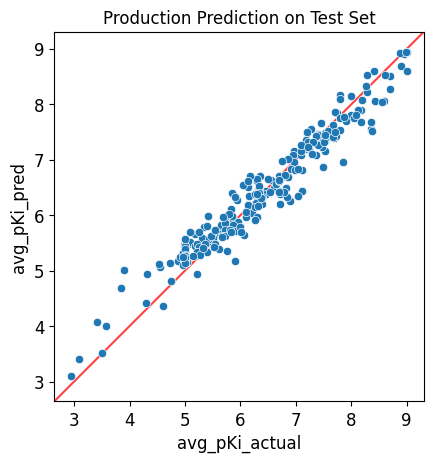

In [28]:
pp.plot_pred_vs_actual_from_df(pred_df, actual_col='avg_pKi_actual', pred_col='avg_pKi_pred', label='Production Prediction on Test Set');

In [29]:
# Production model path
production_model.params.model_tarball_path

'dataset/SLC6A3_models/SLC6A3_Ki_curated_model_8242ce83-1c2d-42c1-ba5d-60fd4bef11be.tar.gz'

Future queries for this dataset will use this production model for prediction. In the next Tutorial 9, you'll explore visualization methods for presenting the predicted result for the production model.